In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import cmocean as cm
import matplotlib.colors as colors

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
def plot_ts(filename, fig=None, ax=None, color='red'):
    if fig == ax == None:
        fig = plt.figure(figsize=(20,5))
        ax = fig.add_subplot(111)
        ax.set_xlabel('Month/Day in 2010', size=14, color='k')
    areas = xr.open_dataarray(filename)    
    fmt = mdates.DateFormatter('         %b')

    ax.plot(areas.ocean_time, areas/1e6, c=color)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(fmt)
    ax.set_xlim(areas.ocean_time[0].data, areas.ocean_time[-1].data)
    ax.set_ylabel(r'Hypoxic area [km$^2$]', size=12, color='k')

    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.text(.1, .7, r'DO$<60 \mu M$', transform=ax.transAxes, fontsize=14)

In [3]:
def plot_wind(filename, fig=None, ax=None, scale=200, cmap='Blues'):
    if fig == ax == None:
        fig = plt.figure(figsize=(20,5))
        ax = fig.add_subplot(111)
        cax = fig.add_axes([0.55, 0.8, 0.3, 0.05])  # colorbar axes
    else:
        cax = None
    wind = xr.open_dataset(filename)
    fmt = mdates.DateFormatter('         %b')
    mappable = ax.quiver(wind.ocean_time.data[::12], 0, wind.uwind[::12], wind.vwind[::12], 
              scale=scale,zorder=3)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(fmt)
    ax.tick_params(left = False, labelleft = False )

    if cax:
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
        cb.set_label(r'Wind speed [$m \cdot s^{-1}$]')
    return mappable

In [4]:
def plot_histo(filename, fig=None, ax=None, vcrit=None, cmap='Blues'):
    if fig == ax == None:
        fig = plt.figure(figsize=(20,5))
        ax = fig.add_subplot(111)
        cax = fig.add_axes([0.55, 0.8, 0.3, 0.05])
    else:
        cax = None
    hist = xr.open_dataarray(filename)
    fmt = mdates.DateFormatter('         %b')
    mappable = ax.pcolormesh(hist.ocean_time, hist.bins, hist.T/1e6,
                             norm=colors.LogNorm(), cmap=cmap, vmin= 10, zorder=3)

    weights = hist/hist.sum(dim='bins')
    ax.plot(hist.ocean_time, (hist.bins*weights).sum(dim='bins'), 'k', zorder=4)
    
    if vcrit:
        ax.axhline(y=vcrit, ls=':', color='k', zorder=5)
        
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(fmt)
    ax.set_ylabel(r'DO [$\mu$M]')
    ax.set_ylim([0,300])

    if cax:
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
        cb.set_label(r'Area with hypoxic bottom [km$^2$]')

    return mappable

In [5]:
ds = xr.open_mfdataset('/d1/shared/TXLA_ROMS/output_20yr_obc/2010/ocean_his_00*.nc',
#                        combine='nested',
                       concat_dim='ocean_time',
                       data_vars='minimal',
                       coords='minimal',
                       parallel=True,
                       chunks={'ocean_time': 1})

/opt/miniconda3/envs/pong/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  import sys
/opt/miniconda3/envs/pong/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, ple

In [6]:
def rot2d(x, y, ang):
    '''rotate vectors by geometric angle'''
    xr = x*np.cos(ang) - y*np.sin(ang)
    yr = x*np.sin(ang) + y*np.cos(ang)
    return xr, yr

In [8]:
etas = slice(71, 141)
xis = slice(263, 376)
uwind, vwind = rot2d(ds.Uwind, ds.Vwind, ds.angle)
uwind = uwind.isel(eta_rho=etas, xi_rho=xis).mean(dim=['eta_rho', 'xi_rho'])
vwind = vwind.isel(eta_rho=etas, xi_rho=xis).mean(dim=['eta_rho', 'xi_rho'])
wind_10 = xr.Dataset({'uwind':uwind, 'vwind':vwind})
wind_10.to_netcdf('wind_2010.nc')

In [12]:
dA = (1/(ds.pn*ds.pn)).isel(eta_rho=etas, xi_rho=xis, drop=True)
bdo = ds.dye_01.isel(s_rho=0, eta_rho=etas, xi_rho=xis, drop=True)
area = dA.where(bdo<=60.).sum(dim=['eta_rho', 'xi_rho']).compute()

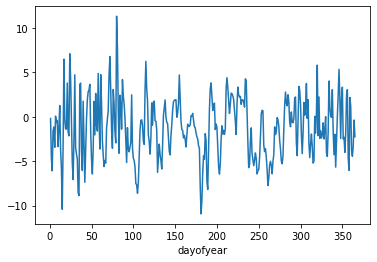

In [13]:
uwd = uwind.groupby('ocean_time.dayofyear').mean('ocean_time')
vwd = vwind.groupby('ocean_time.dayofyear').mean('ocean_time')
uwd.plot()

In [14]:
slices = [slice('2010-07-10','2010-08-03'), 
          slice('2010-08-04','2010-08-31'), 
          slice('2010-09-01','2010-09-27')]

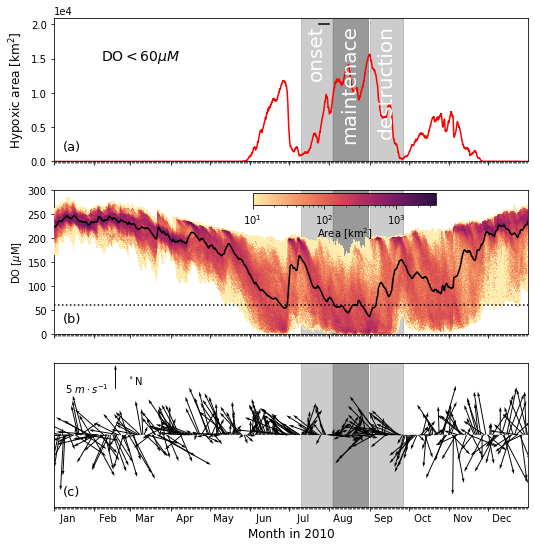

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8.5,9), sharex=True)
plot_ts('files/areas_2010.nc', fig=fig, ax=axes[0])
axes[0].set_ylim(0., 2.1e4)
axes[0].plot([dt.datetime(2010,7,24,0), dt.datetime(2010,7,31,23)], [20000, 20000], 'k', zorder=3)

h = plot_histo('files/hist_2010.nc', vcrit=60., fig=fig, ax=axes[1], cmap=cm.cm.matter)
cax = fig.add_axes([0.45, 0.59, 0.3, 0.02])
cbh = fig.colorbar(h, cax=cax, orientation='horizontal')
cbh.set_label(r'Area [km$^2$]', labelpad=-1)

w = axes[2].quiver(uwind.ocean_time.data[11::24], 0, uwd, vwd, 
                   scale=100, width= 2e-3, zorder=3)
axes[2].quiverkey(w, 0.13, 0.82, 5, r'5 $m \cdot s^{-1}$', angle = 90, labelpos = 'W',
               coordinates='axes')
axes[2].text(0.155, 0.85, '$^\circ$N', transform=axes[2].transAxes)

axes[2].xaxis.set_major_locator(mdates.MonthLocator())
axes[2].xaxis.set_minor_locator(mdates.DayLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('         %b'))
axes[2].tick_params(left = False, labelleft = False )
axes[2].set_xlabel('Month in 2010', size=12)

axes[0].axvspan(slices[0].start, slices[0].stop, alpha=0.4, color='grey', zorder=1)
axes[1].axvspan(slices[0].start, slices[0].stop, alpha=0.4, color='grey', zorder=1)
axes[2].axvspan(slices[0].start, slices[0].stop, alpha=0.4, color='grey', zorder=1)
axes[0].axvspan(slices[1].start, slices[1].stop, alpha=0.8, color='grey', zorder=1)
axes[1].axvspan(slices[1].start, slices[1].stop, alpha=0.8, color='grey', zorder=1)
axes[2].axvspan(slices[1].start, slices[1].stop, alpha=0.8, color='grey', zorder=1)
axes[0].axvspan(slices[2].start, slices[2].stop, alpha=0.4, color='grey', zorder=1)
axes[1].axvspan(slices[2].start, slices[2].stop, alpha=0.4, color='grey', zorder=1)
axes[2].axvspan(slices[2].start, slices[2].stop, alpha=0.4, color='grey', zorder=1)

axes[0].text(.02,.08, '(a)', transform=axes[0].transAxes, fontsize=13)
axes[1].text(.02,.08, '(b)', transform=axes[1].transAxes, fontsize=13)
axes[2].text(.02,.08, '(c)', transform=axes[2].transAxes, fontsize=13)

axes[0].text(dt.datetime.fromisoformat(slices[0].start)+dt.timedelta(days=12),2e4,
             'onset', rotation='vertical', fontsize=20, ha='center', va='top', color='w', zorder=2)
axes[0].text(dt.datetime.fromisoformat(slices[1].start)+dt.timedelta(days=13),2e4,
             'maintenace', rotation='vertical', fontsize=20, ha='center', va='top', color='w', zorder=2)
axes[0].text(dt.datetime.fromisoformat(slices[2].start)+dt.timedelta(days=13),2e4,
             'destruction', rotation='vertical', fontsize=20, ha='center', va='top', color='w', zorder=2)
# # fig.tight_layout(pad=0.5)
fig.savefig('figures/hypoxia_2010.png', transparent=True)